<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [2]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [3]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [4]:
if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


# Assignments:

1. Add another feature called  Preferential Attachment  with followers and followees data of vertex. you can check about Preferential Attachment in below link
http://be.amazd.com/link-prediction/ <br>
2. Add  feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features.  you can read about this in below pdf 
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf<br>
3. Tune hyperparameters for XG boost with all these features and check the error metric.

## Extra Features 

## Preferential Attachment feature

In [5]:
def preferential_attachment_follower(u,v):
    try:
        return (len(set(train_graph.predecessors(u))) * len(set(train_graph.predecessors(v))))
    except:
        return -1
df_final_train['preferential_attachment_follower'] = df_final_train.apply(lambda x: preferential_attachment_follower(x['source_node'],x['destination_node']), axis=1)

In [6]:
df_final_test['preferential_attachment_follower'] = df_final_test.apply(lambda x: preferential_attachment_follower(x['source_node'],x['destination_node']), axis=1)

In [7]:
def preferential_attachment_followee(u,v):
    try:
        return (len(set(train_graph.successors(u))) * len(set(train_graph.successors(v))))
    except:
        return -1
df_final_train['preferential_attachment_followee'] = df_final_train.apply(lambda x: preferential_attachment_follower(x['source_node'],x['destination_node']), axis=1)

In [8]:
df_final_test['preferential_attachment_followee'] = df_final_test.apply(lambda x: preferential_attachment_follower(x['source_node'],x['destination_node']), axis=1)

## Svd_dot feature

In [9]:
df_final_train['svd_dot_u'] = \
df_final_train.apply(lambda x: np.matmul(np.array(x[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4','svd_u_s_5', 'svd_u_s_6']])\
                    ,np.array(x[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3','svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6']]).T)\
                    ,axis=1)
df_final_train['svd_dot_v'] = \
df_final_train.apply(lambda x: np.matmul(np.array(x[['svd_v_s_1', 'svd_v_s_2','svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']])\
                    ,np.array(x[['svd_v_d_1','svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']]).T)\
                    ,axis=1)

df_final_test['svd_dot_u'] = \
df_final_test.apply(lambda x: np.matmul(np.array(x[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4','svd_u_s_5', 'svd_u_s_6']])\
                    ,np.array(x[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3','svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6']]).T)\
                    ,axis=1)
df_final_test['svd_dot_v'] = \
df_final_test.apply(lambda x: np.matmul(np.array(x[['svd_v_s_1', 'svd_v_s_2','svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']])\
                    ,np.array(x[['svd_v_d_1','svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']]).T)\
                    ,axis=1)

#### follow_followee feature: gives -high num if the source node is celebrity and +high if destination node is

In [10]:
def follow_followee(u,v):
    try:
        return (len(set(train_graph.predecessors(u))) - len(set(train_graph.successors(u)))) - (len(set(train_graph.predecessors(v))) - 
                                                                                                len(set(train_graph.successors(v))))
    except:
        return -1
df_final_train['u_follow_followee-v_follow_followee'] = df_final_train.apply(lambda x: follow_followee(x['source_node'],x['destination_node']), axis=1)

In [11]:
df_final_test['u_follow_followee-v_follow_followee'] = df_final_test.apply(lambda x: follow_followee(x['source_node'],x['destination_node']), axis=1)

<ul><b>num_u_followings_following_v</b>:  number of followee of u is following v</ul>
<ul><b>num_v_followings_following_u</b>:  number of followee of v is following u</ul>
<ul><b>num_u_followers_following_v</b>:  number of followers of u is following v</ul>
<ul><b>num_v_followers_following_u</b>:  number of followers of v is followers u</ul>

In [12]:
def num_u_followings_following_v(u,v):
    try:
        u_followers_following_v = 0
        for pred in  set(train_graph.successors(u)):
            if v in set(train_graph.successors(pred)):
                u_followers_following_v+=1
        return u_followers_following_v
    except:
        return -1
    
    
df_final_train['num_u_followings_following_v'] = df_final_train.apply(lambda x: num_u_followings_following_v(x['source_node'],x['destination_node']), axis=1)
df_final_test['num_u_followings_following_v'] = df_final_test.apply(lambda x: num_u_followings_following_v(x['source_node'],x['destination_node']), axis=1)


def num_v_followings_following_u(u,v):
    try:
        v_followers_following_u = 0
        for pred in  set(train_graph.successors(v)):
            if u in set(train_graph.successors(pred)):
                v_followers_following_u+=1
        return v_followers_following_u
    except:
        return -1
    
    
df_final_train['num_v_followings_following_u'] = df_final_train.apply(lambda x: num_v_followings_following_u(x['source_node'],x['destination_node']), axis=1)
df_final_test['num_v_followings_following_u'] = df_final_test.apply(lambda x: num_v_followings_following_u(x['source_node'],x['destination_node']), axis=1)

In [13]:
def num_u_followers_following_v(u,v):
    try:
        u_followers_following_v = 0
        for pred in  set(train_graph.predecessors(u)):
            if v in set(train_graph.successors(pred)):
                u_followers_following_v+=1
        return u_followers_following_v
    except:
        return -1
    
    
df_final_train['num_u_followers_following_v'] = df_final_train.apply(lambda x: num_u_followers_following_v(x['source_node'],x['destination_node']), axis=1)
df_final_test['num_u_followers_following_v'] = df_final_test.apply(lambda x: num_u_followers_following_v(x['source_node'],x['destination_node']), axis=1)


def num_v_followers_following_u(u,v):
    try:
        v_followers_following_u = 0
        for pred in  set(train_graph.predecessors(v)):
            if u in set(train_graph.successors(pred)):
                v_followers_following_u+=1
        return v_followers_following_u
    except:
        return -1
    
    
df_final_train['num_v_followers_following_u'] = df_final_train.apply(lambda x: num_v_followers_following_u(x['source_node'],x['destination_node']), axis=1)
df_final_test['num_v_followers_following_u'] = df_final_test.apply(lambda x: num_v_followers_following_u(x['source_node'],x['destination_node']), axis=1)

In [14]:
df_train_temp = df_final_train.copy()
df_test_temp = df_final_test.copy()

In [15]:
df_final_train = df_train_temp.copy()
df_final_test = df_test_temp.copy()

<h3>Removing correlation as they will make model miss important correlations between the independent variables and the class labels, thereby underfitting the model

In [16]:
# removing correlated data as they will help make useful feature interactions 
#rather than correlated one's hence underfit the model

def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                print("Removed features are :-",colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    return col_corr
col_corr = correlation(df_final_train, 0.90)
for i in list(col_corr):
    df_final_test = df_final_test.drop([i], axis=1)

Removed features are :- cosine_followees
Removed features are :- adar_index
Removed features are :- weight_f2
Removed features are :- weight_f3
Removed features are :- weight_f3
Removed features are :- weight_f4
Removed features are :- weight_f4
Removed features are :- katz_d
Removed features are :- authorities_s
Removed features are :- svd_u_s_6
Removed features are :- svd_u_d_1
Removed features are :- svd_u_d_6
Removed features are :- svd_v_s_1
Removed features are :- svd_v_s_4
Removed features are :- svd_v_s_6
Removed features are :- svd_v_d_1
Removed features are :- svd_v_d_6
Removed features are :- preferential_attachment_followee
Removed features are :- num_u_followers_following_v
Removed features are :- num_v_followers_following_u


In [17]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'num_followers_s', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'page_rank_s',
       'page_rank_d', 'katz_s', 'hubs_s', 'hubs_d', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_5', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4',
       'svd_v_d_5', 'preferential_attachment_follower', 'svd_dot_u',
       'svd_dot_v', 'u_follow_followee-v_follow_followee',
       'num_u_followings_following_v', 'num_v_followings_following_u'],
      dtype='object')

In [18]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [19]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9287073142532819 test Score 0.9234611802556938
Estimators =  50 Train Score 0.9288736312767051 test Score 0.9226635069084446
Estimators =  100 Train Score 0.9278233557780182 test Score 0.9240255078339458
Estimators =  250 Train Score 0.9266580960610339 test Score 0.9238555033244398
Estimators =  450 Train Score 0.9270547115981851 test Score 0.9235198238817975


Text(0.5,1,'Estimators vs score at depth of 5')

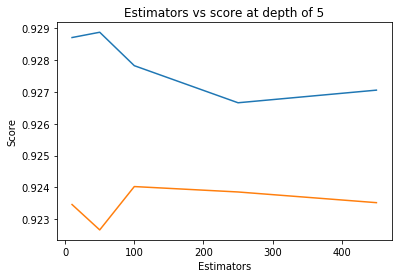

In [20]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8910515890104211 test Score 0.8713543835046125
depth =  9 Train Score 0.9544221655868416 test Score 0.9269678288130957
depth =  11 Train Score 0.9615615921716528 test Score 0.927783751871297
depth =  15 Train Score 0.9644453039911239 test Score 0.9294663573085847
depth =  20 Train Score 0.9642984321426028 test Score 0.9287114934530962
depth =  35 Train Score 0.9641306227054075 test Score 0.9284811193526635
depth =  50 Train Score 0.9641306227054075 test Score 0.9284811193526635
depth =  70 Train Score 0.9641306227054075 test Score 0.9284811193526635
depth =  130 Train Score 0.9641306227054075 test Score 0.9284811193526635


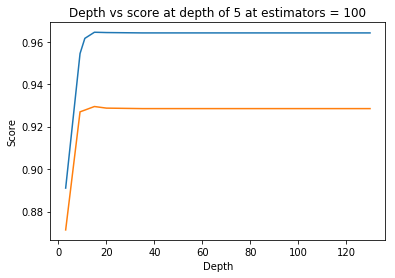

In [21]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 100')
plt.show()

In [22]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(90,110),
              "max_depth": sp_randint(3,25),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.93448592 0.96497739 0.96541439 0.92909052 0.96568796]
mean train scores [0.93483896 0.96614765 0.96641651 0.92902554 0.96679222]


In [23]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=23, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=106, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)


In [24]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=23, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=106, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [25]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [26]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9666388657214346
Test f1 score 0.9302993203022755


In [27]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


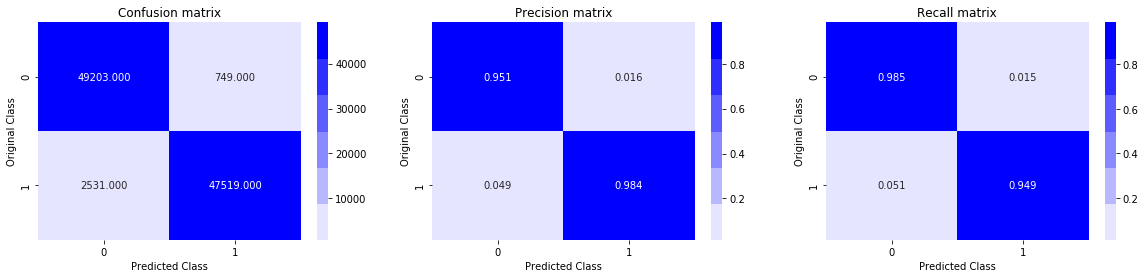

Test confusion_matrix


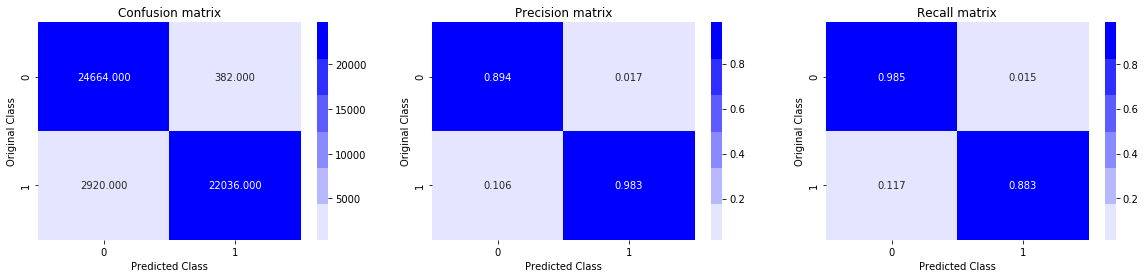

In [28]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

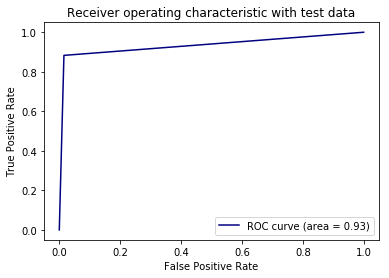

In [29]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

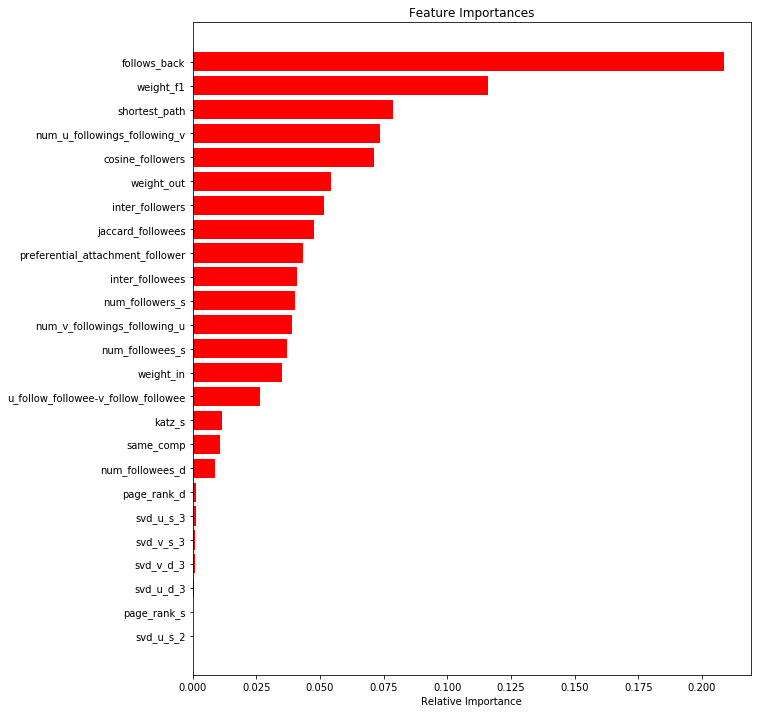

In [30]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [31]:
# Conclusion

# using simple feature like follows_back and num_u_followings_following_v from domain knowlege which are very powerful 

# removing correlated features reduces underfitting hence reducing complexity of the model

# DT performs well whereever feature interactions are needed